# Using the DESI AGN / QSO Value-Added Catalog
**Authors:** Becky Canning (University of Portsmouth), Stephanie Juneau (NSF NOIRLab), Mar Mezcua (ICE, CSIC), Rahma Alfarsy (University of Portsmouth), Shree Behera (Kansas State University), Ben Floyd (University of Portsmouth), Claire Greenwell (Durham University), Raga Pucha (University of Utah), Sai Srinivas (University of Portsmouth), Gosia Suidek (Instituto Astrofisica de Canarias), Galaxy & Quasar Physics (GQP) working group  


## Overview

This DESI DR1 value-added catalog (VAC; Juneau, Canning, Mezcua et al., in prep.) includes **galaxies and quasars** from all targets (MWS, BGS, LRG, ELG, QSO as well as secondary targets; [Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract)). 
The DESI Redrock pipeline (Bailey et al., in prep.) assigns a spectral type (`SPECTYPE='STAR', 'GALAXY' or 'QSO'`) and a redshift (`Z`) to all spectra. 
Then the machine-learning algorithm QuasarNet and the MgII post-processing pipeline are used to improve the quasar classification and redshift estimated ([Chaussidon et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...944..107C/abstract), [Alexander et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..124A/abstract)). 

Starting from a selection of extragalactic spectra (`Z>0.001`), this catalog includes classifications based on optical and ultraviolet diagrams using emission line measurements from FastSpecFit ([Moustakas et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ascl.soft08005M/abstract)). 
We use FastSpecFit v2.1, corresponding to the Iron value-added catalog released as the DESI First Data Release (DESI/DR1): 
<https://fastspecfit.readthedocs.io/en/latest/iron.html>. The catalog also incorporates mid-infrared classifications 
based on Tractor WISE photometry ([Lang et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ascl.soft04008L/abstract)).


## Important notes
If you use the DESI DR1 AGN/QSO VAC and/or this example notebook:
- Please cite S. Juneau, et al. (in prep.)
- To run the notebook, make sure to also download the following accompanying files:
    - agnmask.yaml
    - desiutil_bitmask.py
- Please also consult with [VAC Readme file](https://data.desi.lbl.gov/doc/releases/dr1/vac/agnqso/) for the list of citations that go along the AGN diagnostic diagrams
- If you have questions or issues, contact Stephanie Juneau, Becky Canning or Mar Mezcua

### 1) First let's import some stuff!

In [8]:
# Numpy
import numpy as np
# Plotting stuff and suppressing boring warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

# Get the GQP code
import sys
# Set the path where the py scripts are
#sys.path.append("../py/")

# Import Astropy libraries - useful for many astronomy related function
from astropy.table import Table
from astropy.io import fits
import fitsio

# TO DO: simplify/clean this?
settings = {
    'font.size':12,
    'axes.linewidth':2.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':1.,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':1.,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True,
    'axes.labelsize':14
}

plt.rcParams.update(**settings)

### Define a function that will be needed to decode the bitmasks

In [9]:
def get_agn_maskbits(file):
    import yaml
    from desiutil_bitmask import BitMask
    file_yaml = open(file, 'r')
    yaml_defs = yaml.safe_load(file_yaml)
    
    AGN_MASKBITS = BitMask('AGN_MASKBITS', yaml_defs)
    OPT_UV_TYPE = BitMask('OPT_UV_TYPE', yaml_defs)
    IR_TYPE = BitMask('IR_TYPE', yaml_defs)
    
    return AGN_MASKBITS, OPT_UV_TYPE, IR_TYPE

### 2) Now we are ready to open the catalog.

The public location of the catalog is: https://data.desi.lbl.gov/public/dr1/vac/dr1/agnqso

For users with NERSC access, the catalog can be found here: `/global/cfs/cdirs/desi/public/dr1/vac/dr1/agnqso/v1.0/`

**NOTE:** The fits file is large (8.7 GB) so it can take a while to read it in its entirety. 

In [10]:
# Set the directory of the catalog file here:
#catdir = '/global/cfs/cdirs/desi/public/dr1/vac/dr1/agnqso/v1.0/'  # NERSC
catdir = '/global/cfs/cdirs/desi/science/gqp/agncatalog/catalog/' # test EDR 
#catdir = './' # Local copy

In [11]:
# Open the catalog
#agn_hdul = fits.open(f'{catdir}agnqso_desi.fits', format='fits')
agn_hdul = fits.open(f'{catdir}agnqso_sum_edr_units.fits', format='fits')
agn_hdul.info()

Filename: /global/cfs/cdirs/desi/science/gqp/agncatalog/catalog/agnqso_sum_edr_units.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  AGNCAT        1 BinTableHDU    101   1397603R x 35C   [K, 7A, 6A, J, D, D, K, 6A, K, K, K, J, D, D, K, D, D, D, I, E, L, L, K, K, K, K, K, K, K, K, K, K, K, K, K]   
  2  AUXDATA       1 BinTableHDU    182   1397603R x 58C   [K, 7A, 6A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


As we can see there are two extensions:
- Ext[1] is called AGNCAT and includes the catalog of galaxies and quasars with classifications
- Ext[2] is called AUXDATA and includes the auxilary data used for creating the diagnostics diagrams (emission line measurements and stellar mass estimate from FastSpecFit; WISE fluxes from Tractor)

Below we will read both extensions at `T` for the main table, and `T2` for extension 2.

In [12]:
%%time
# Load the catalog into Astropy tables
T = Table(agn_hdul[1].data)
T2 = Table(agn_hdul[2].data)

CPU times: user 4.15 s, sys: 940 ms, total: 5.09 s
Wall time: 5.16 s


Let's print the columns in this catalog.

In [13]:
# What are the columns in the first extension?
T.columns

<TableColumns names=('TARGETID','SURVEY','PROGRAM','HEALPIX','Z','ZERR','ZWARN','SPECTYPE','AGN_MASKBITS','OPT_UV_TYPE','IR_TYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','LS_ID','MIN_MJD','MEAN_MJD','MAX_MJD','COADD_NUMEXP','COADD_EXPTIME','SV_PRIMARY','ZCAT_PRIMARY','DESI_TARGET','SCND_TARGET','BGS_TARGET','CMX_TARGET','SV1_DESI_TARGET','SV2_DESI_TARGET','SV3_DESI_TARGET','SV1_BGS_TARGET','SV2_BGS_TARGET','SV3_BGS_TARGET','SV1_SCND_TARGET','SV2_SCND_TARGET','SV3_SCND_TARGET')>

In particular we acess information about the AGN and QSO diagnostics via the AGN_MASKBITS and OPT_UV_TYPE columns. We can read the definitions for the bitmasks in the yaml file.

In [14]:
AGN_MASKBITS, OPT_UV_TYPE, IR_TYPE = get_agn_maskbits('../py/agnmask.yaml')

These are the bitmask which contain the infomation. The format of these bitmasks is:    

    - [name of the target bit,  bit value,  "description as a string"]
    
For example:

    - [NII_SY,           8, "NII BPT Seyfert"]
    
This means the name of the target bit is NII_SY, its bit value is 2$^{8}$ and its description is a Seyfert object according to the NII BPT.

So let's see what the bitmasks look like.

In [15]:
print(AGN_MASKBITS)

AGN_MASKBITS:
  - [AGN_ANY,          0, "any AGN classification is set"]
  - [RR,               1, "RR determines this to be a QSO from template fitting"]
  - [MGII,             2, "MgII afterburner detects broad line"]
  - [QN,               3, "Quasar Net reclassifies as a QSO"]
  - [QN_NEW_RR,        4, "Quasar Net prompts different RR redshift"]
  - [QN_BGS,           5, "Quasar Net reclassifies BGS target as a QSO"]
  - [QN_ELG,           6, "Quasar Net reclassifies ELG target as a QSO"]
  - [QN_VAR_WISE,      7, "Quasar Net reclassifies VAR_WISE_QSO target as a QSO"]
  - [BPT_ANY_SY,      10, "At least one BPT diagnostic indicates SEYFERT (robust AGN)"]
  - [BPT_ANY_AGN,     11, "At least one BPT diagnostic indicates SEYFERT, LINER or COMPOSITE"]
  - [BROAD_LINE,      12, "Lines with FWHM >=1200 km/s in Halpha, Hbeta, MgII and/or CIV line"]
  - [OPT_OTHER_AGN,   13, "Rest frame optical emission lines diagnostic not BPT (4000-10000 ang) indicate AGN"]
  - [UV,              14, "Re

In [16]:
print(OPT_UV_TYPE)

OPT_UV_TYPE:
  - [NII_BPT,          0, "NII BPT diagnostic is available"]
  - [NII_SF,           1, "NII BPT Star-forming"]
  - [NII_COMP,         2, "NII BPT Composite"]
  - [NII_SY,           3, "NII BPT Seyfert"]
  - [NII_LINER,        4, "NII BPT LINER"]
  - [SII_BPT,          5, "SII BPT diagnostic is available"]
  - [SII_SF,           6, "SII BPT Star-forming"]
  - [SII_SY,           7, "SII BPT Seyfert"]
  - [SII_LINER,        8, "SII BPT LINER"]
  - [OI_BPT,           9, "OI BPT diagnostic is available"]
  - [OI_SF,           10, "OI BPT Star-forming"]
  - [OI_SY,           11, "OI BPT Seyfert"]
  - [OI_LINER,        12, "OI BPT LINER"]
  - [WHAN,            13, "WHAN is available (Halpha and [NII])"]
  - [WHAN_SF,         14, "WHAN Star-forming"]
  - [WHAN_SAGN,       15, "WHAN Strong AGN"]
  - [WHAN_WAGN,       16, "WHAN Weak AGN"]
  - [WHAN_RET,        17, "WHAN Retired"]
  - [WHAN_PASS,       18, "WHAN Passive"]
  - [BLUE,            19, "Blue diagram available"]
  - [BLUE_

## 1) How to find the number of certain classes

### Examples: NII BPT LINER and Star-forming (SF) galaxies

In [17]:
is_nii_liner = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_LINER != 0)
len(T[is_nii_liner])

4077

In [18]:
is_nii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SF != 0)
len(T[is_nii_sf])

155350

## 2) How to plot distributions

### Compare redshift distributions of different AGN classes

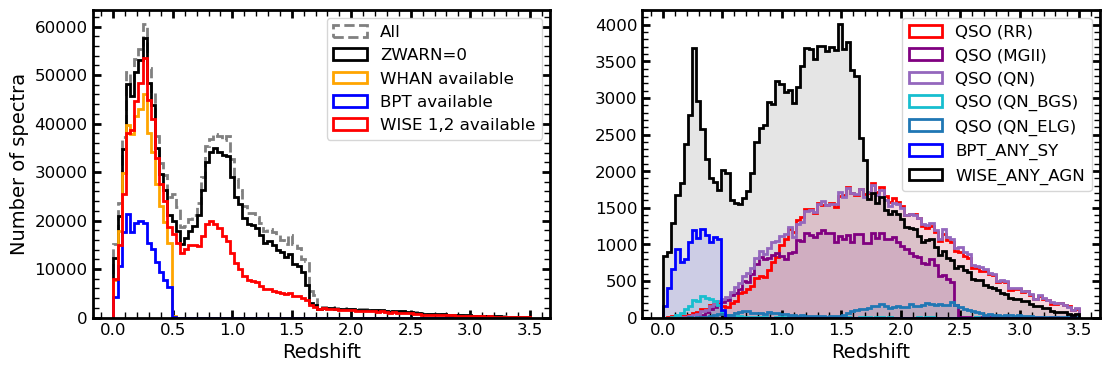

In [19]:
# Labels for the legend, names of AGN types in the mask, colors for plotting 
agnlabels = ['QSO (RR)', 'QSO (MGII)', 'QSO (QN)', 'QSO (QN_BGS)', 'QSO (QN_ELG)', 'BPT_ANY_SY', 'WISE_ANY_AGN']
agntypes = ['RR', 'MGII', 'QN', 'QN_BGS', 'QN_ELG', 'BPT_ANY_SY', 'WISE_ANY_AGN']
colors = ['red', 'purple', 'tab:purple', 'tab:cyan', 'tab:blue', 'blue', 'black']

# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4), sharex=True)

# Default range for plotting redshift 0 < z < 3.5
rz = (0, 3.5)

# Left-hand panel: full catalog + only secure redshifts
ax1.hist(T['Z'],bins=100,range=(rz), histtype='step', lw=2, color='gray', ls='--', label='All')
ax1.hist(T['Z'][T['ZWARN']==0],bins=100,range=(rz), histtype='step', lw=2, color='k', label='ZWARN=0')

# WHAN available
ax1.hist(T['Z'][(T['ZWARN']==0)&(T['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN != 0)],bins=100,range=(rz), 
         histtype='step', lw=2, color='orange', label='WHAN available')

# BPT available
ax1.hist(T['Z'][(T['ZWARN']==0)&(T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_BPT != 0)],bins=100,range=(rz), 
         histtype='step', lw=2, color='b', label='BPT available')

# WISE (W1, W2) available [some diagrams need W1, W2, W3]
ax1.hist(T['Z'][(T['ZWARN']==0)&(T['IR_TYPE'] & IR_TYPE.WISE_W12 != 0)],bins=100,range=(rz), 
         histtype='step', lw=2, color='r', label='WISE 1,2 available')

# Right-hand panel: selected classes of AGN/QSO
for i, agn in enumerate(agntypes):
    sel = (T['AGN_MASKBITS'] & AGN_MASKBITS[agn] != 0)
    col = colors[i]
    ax2.hist(T['Z'][sel],bins=100,range=(rz), alpha=0.1, color=col)
    ax2.hist(T['Z'][sel],bins=100,range=(rz), label=agnlabels[i], histtype='step', lw=2, color=col)

# Axis labels
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of spectra')
ax2.set_xlabel('Redshift')

# Legends
ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
plt.show()

## 3) Let's try to filter by some BPT AGN diagnostics and plot the result.

Let's begin with the BPT plots, which all use log([OIII]/$H\beta$) on the vertical axis as a function of three different line ratios on the horizontal axis: **(a)** log([NII]6584/$H\alpha$), **(b)** log([SII]6717,6731/$H\alpha$), **(c)** log([OI]6300/$H\alpha$).

- [NII] BPT with regions defined as:
    - [Kewley et al. (2001)](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..121K/abstract): Star-forming vs AGN
    - [Kauffmann et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.346.1055K/abstract): Star-forming vs Composite
    - [Schawinsky et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007MNRAS.382.1415S/abstract): Seyfert vs LINER
    - Originally from [Baldwin, Phillips & Terlevich (1981)](https://ui.adsabs.harvard.edu/abs/1981PASP...93....5B/abstract)
- [SII] BPT regions defined as:
    - [Law et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...915...35L/abstract): Star-forming vs AGN
    - [Kewley et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006MNRAS.372..961K/abstract): Seyfert vs LINER
    - Original demarcations from [Veilleux & Osterbrock (1987)](https://ui.adsabs.harvard.edu/abs/1987ApJS...63..295V/abstract)
- [OI] BPT regions defined as:
    - [Law et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...915...35L/abstract): Star-forming vs AGN
    - [Kewley et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006MNRAS.372..961K/abstract): Seyfert vs LINER
    - Original demarcations from [Veilleux & Osterbrock (1987)](https://ui.adsabs.harvard.edu/abs/1987ApJS...63..295V/abstract)

To plot the BPT diagnostic diagrams we'll need to find the logarithm of the ratios needed for the x and y axes.

In [20]:
xx_bptnii = np.log10(T2['NII_6584_FLUX']/T2['HALPHA_FLUX'])
xx_bptsii = np.log10((T2['SII_6716_FLUX']+T2['SII_6731_FLUX'])/T2['HALPHA_FLUX'])
xx_bptoi = np.log10(T2['OI_6300_FLUX']/T2['HALPHA_FLUX'])
yy_bpt = np.log10(T2['OIII_5007_FLUX']/T2['HBETA_FLUX'])

Now let's use our bitmask to filter these vectors. 

As an example let's think about how we might filter the NII BPT star-forming objects. In the OPT_UV_TYPE bitmask the star-forming objects are defined with:

    OPT_UV_TYPE:
    ...
    - [NII_SF,           6, "NII BPT Star-forming"]
    ...
    
Accessing the OPT_UV_TYPE column of our table, T, is done through:

    T['OPT_UV_TYPE']
    
This is where the numeric value associated with our binary number is stored. 
    
We filter a bitmask by identfying a bit that is flipped to a 1. 2^0=1, 2^1=10, 2^2=100, 2^3=1000...

So for example if T['OPT_UV_TYPE'] is 11 then the binary represenation would be 1011 formed from 11 = 8+2+1 = 2^3+2^1+2^0 = 1000 + 10 + 1. 

In this case for the first 4 bitvalues we would find:

for bitnumber of 11

    is 2^0 true = 1
    is 2^1 true = 1
    is 2^2 true = 0
    is 2^3 true = 1
    
in pseudo code we could express this as

    is_0 = ( 11 & 2^0 != 0)
    is_1 = ( 11 & 2^1 != 0)
    is_2 = ( 11 & 2^2 != 0)
    is_3 = ( 11 & 2^3 != 0)
    
Now let's return to think about the case of is our 'OPT_UV_TYPE' diagnostic NII_SF. We could write this as:    

    is_nii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SF != 0)
    


Using this logic, let's try filtering and printing the NII, SII and OI BPT plot.

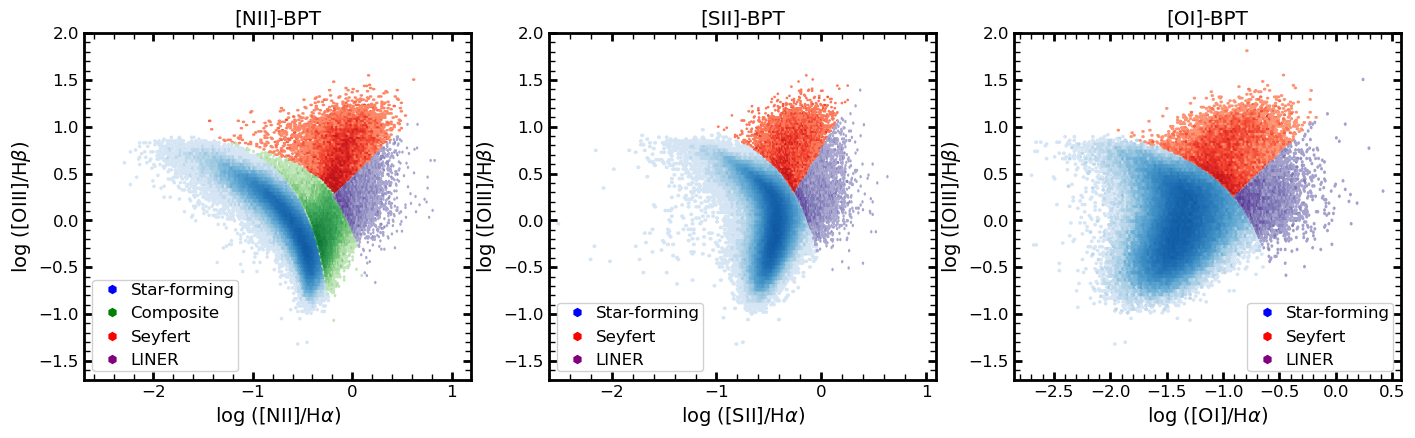

In [21]:
is_nii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SF != 0)
is_nii_sy = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SY != 0)
is_nii_lin = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_LINER != 0)
is_nii_comp = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_COMP != 0)

is_sii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_SF != 0)
is_sii_sy = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_SY != 0)
is_sii_lin = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_LINER != 0)

is_oi_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_SF != 0)
is_oi_sy = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_SY != 0)
is_oi_lin = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_LINER != 0)

## Parameters for all plots
norm_min, norm_max = 0.3, 300

## Initialize figure
plt.figure(figsize = (17,4.5))

plt.subplot2grid((1,3), (0,0))
plt.title('[NII]-BPT')
plt.hexbin(xx_bptnii[is_nii_sf], yy_bpt[is_nii_sf], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Blues')
plt.hexbin(xx_bptnii[is_nii_sy], yy_bpt[is_nii_sy], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Reds')
plt.hexbin(xx_bptnii[is_nii_comp], yy_bpt[is_nii_comp], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Greens')
plt.hexbin(xx_bptnii[is_nii_lin], yy_bpt[is_nii_lin], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Purples')
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.xlim(-2.7,1.2)
plt.ylim(-1.7,2)

legend_elements = [
    Line2D([0], [0], marker='h', color='w', markerfacecolor='b', markersize=8, label="Star-forming"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='g', markersize=8, label="Composite"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='r', markersize=8, label="Seyfert"), 
    Line2D([0], [0], marker='h', color='w', markerfacecolor='purple', markersize=8, label="LINER")
]
plt.legend(handles=legend_elements, loc='lower left', fontsize=12, framealpha=0.9, 
           handletextpad=0.1, borderpad=0.2)

plt.subplot2grid((1,3), (0,1))
plt.title('[SII]-BPT')
plt.hexbin(xx_bptsii[is_sii_sf], yy_bpt[is_sii_sf], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Blues')
plt.hexbin(xx_bptsii[is_sii_sy], yy_bpt[is_sii_sy], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Reds')
plt.hexbin(xx_bptsii[is_sii_lin], yy_bpt[is_sii_lin], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Purples')
plt.xlabel('log ([SII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.xlim(-2.6,1.1)
plt.ylim(-1.7,2)

legend_elements = [
    Line2D([0], [0], marker='h', color='w', markerfacecolor='b', markersize=8, label="Star-forming"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='r', markersize=8, label="Seyfert"), 
    Line2D([0], [0], marker='h', color='w', markerfacecolor='purple', markersize=8, label="LINER")
]
plt.legend(handles=legend_elements, loc='lower left', fontsize=12, framealpha=0.9, 
           handletextpad=0.1, borderpad=0.2)

plt.subplot2grid((1,3), (0,2))
plt.title('[OI]-BPT')
plt.hexbin(xx_bptoi[is_oi_sf], yy_bpt[is_oi_sf], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Blues')
plt.hexbin(xx_bptoi[is_oi_sy], yy_bpt[is_oi_sy], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Reds')
plt.hexbin(xx_bptoi[is_oi_lin], yy_bpt[is_oi_lin], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Purples')
plt.xlabel('log ([OI]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.ylim(-1.7,2)

legend_elements = [
    Line2D([0], [0], marker='h', color='w', markerfacecolor='b', markersize=8, label="Star-forming"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='r', markersize=8, label="Seyfert"), 
    Line2D([0], [0], marker='h', color='w', markerfacecolor='purple', markersize=8, label="LINER")
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12, framealpha=0.9, 
           handletextpad=0.1, borderpad=0.2)

plt.show()

### 4) Let's plot all the diagnostics we have

The [NII], [SII] and [OI] BPT-type diagnostic diagrams are plotted above. The other optical and UV diagnostics are:

1. He II BPT
2. WHAN diagram
3. Blue diagram
4. MEx diagram
5. KEx diagram
6. WISE colors

Let's try these in order below.

#### 1) He II $\lambda$4686 diagnostic

Diagnostic diagram from [Shirazi & Brinchmann (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.421.1043S/abstract)

In [22]:
xx_bptnii = np.log10(T2['NII_6584_FLUX']/T2['HALPHA_FLUX'])
yy_bptheii = np.log10(T2['HEII_4686_FLUX']/T2['HBETA_FLUX'])

In [23]:
is_heii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.HEII_SF != 0)
is_heii_agn = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.HEII_AGN != 0)

In [24]:
# log10(flux_heii_4685/flux_hbeta)=-1.22+1/(8.92*log10(flux_nii_6583/flux_halpha)+1.32)
x_heiiline = np.linspace(-3,-1.32/8.92,70)
y_heiiline = -1.22+1/(8.92*x_heiiline+1.32)

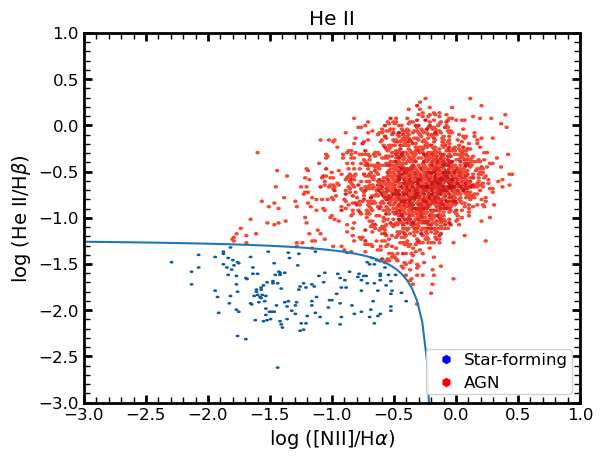

In [25]:
norm_min, norm_max = 0.3, 300
color = cm.PuRd(0.5)

plt.title('He II')
plt.hexbin(xx_bptnii[is_heii_sf], yy_bptheii[is_heii_sf], bins=100, norm=LogNorm(norm_min, norm_max), cmap = 'Blues')
plt.hexbin(xx_bptnii[is_heii_agn], yy_bptheii[is_heii_agn], bins=100, norm=LogNorm(norm_min, norm_max), cmap = 'Reds')
plt.plot(x_heiiline, y_heiiline)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log (He II/H$\\beta$)')
plt.xlim(-3, 1)
plt.ylim(-3, 1)

legend_elements = [
    Line2D([0], [0], marker='h', color='w', markerfacecolor='b', markersize=8, label="Star-forming"), 
    Line2D([0], [0], marker='h', color='w', markerfacecolor='r', markersize=8, label="AGN")
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12, framealpha=0.9, 
           handletextpad=0.1, borderpad=0.2)
plt.show()

#### 2) WHAN: $W_{H\alpha}$ versus [N II]/$H\alpha$

Developed by [Cid Fernandes et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011MNRAS.413.1687C/abstract). As reported in that paper, "Five classes of galaxies are identified within the WHAN diagram:"
- i) pure star-forming galaxies: log([NII]6584/$H\alpha$) < -0.4 and WHα > 3 Å;
- ii) strong AGN (i.e. Seyferts): log([NII]6584/$H\alpha$) > -0.4 and WHα > 6 Å;
- iii) weak AGN: log([NII]6584/$H\alpha$) > -0.4 and WHα between 3 and 6 Å;
- iv) RGs (i.e. fake AGN): WHα < 3 Å;
- v) passive galaxies (actually, lineless galaxies): WHα and W[N II] < 0.5 Å.

In [26]:
#we define the masks required for the classification of AGNs for the WHAN BPT diagram
is_whan_av = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN !=0)
#creating the subcatalog for the objects for which the WHAN is available
T_WHAN = T[is_whan_av]
T2_WHAN = T2[is_whan_av]
xx_bptwhan=np.log10((T2_WHAN['NII_6584_FLUX']/T2_WHAN['HALPHA_FLUX'])) 
yy_Wha = T2_WHAN['HALPHA_EW'] #getting the width of H-alpha line
#creating the masks for different WHAN objects
is_whan_sf = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_SF !=0)  #Star forming galaxies mask
is_whan_sagn = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_SAGN != 0) #strong AGN mask
is_whan_wagn = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_WAGN != 0) #weak AGN mask
is_whan_ret = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_RET !=0) #retired galaxies mask
is_whan_pass = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_PASS !=0) #passive galaxies mask

#for passive galaxies, filter required to remove negative values encountered
x_passive = xx_bptwhan[is_whan_pass] 
y_passive = yy_Wha[is_whan_pass]
passive_mask = y_passive>0.
x_passive = x_passive[passive_mask]
y_passive = y_passive[passive_mask]

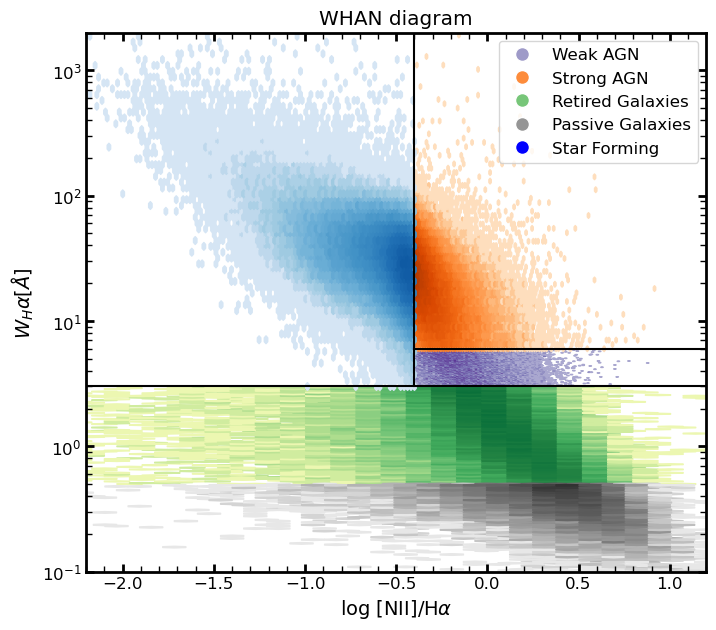

In [27]:
#initializing the figure properties
plt.figure(figsize=(8,7))
plt.title('WHAN diagram')

#creating the WHAN BPT diagram
plt.hexbin(xx_bptwhan[is_whan_wagn], yy_Wha[is_whan_wagn], cmap='Purples', bins=100, norm=LogNorm(norm_min, norm_max), yscale='log')
plt.hexbin(xx_bptwhan[is_whan_sagn], yy_Wha[is_whan_sagn], cmap = 'Oranges', bins=100, norm=LogNorm(norm_min, norm_max), yscale='log')
plt.hexbin(xx_bptwhan[is_whan_ret], yy_Wha[is_whan_ret], cmap = 'YlGn', bins=100, norm=LogNorm(norm_min, norm_max), yscale='log')
plt.hexbin(x_passive, y_passive, cmap='Greys', bins=100, yscale='log', norm=LogNorm(norm_min, norm_max))
#defining the theoretical cuts for different objects
x_cutoff_SF = -0.4 
plt.hexbin(xx_bptwhan[is_whan_sf], yy_Wha[is_whan_sf], cmap = 'Blues', bins=100, norm=LogNorm(norm_min, norm_max), yscale='log')

#star forming WHAN cutoff criteria
plt.plot([x_cutoff_SF, x_cutoff_SF], [3, 2e3], color='black')
y_cutoff_sAGN = 6 #strong AGN WHAN cutoff criteria
plt.plot([-0.4, 1.2], [y_cutoff_sAGN, y_cutoff_sAGN], color='black')
plt.axhline(y=3, color='black') #criteria for the retired galaxies, also referred to as the fake AGNs
plt.xlabel('log [NII]/H$\\alpha$') 
plt.ylabel('$W_H\\alpha [{\AA}]$')
plt.yscale('log')
#defining the limits of the plot
plt.xlim(-2.2, 1.2)
plt.ylim(0.1, 2e3)
#defining the legends of the scatter plot separately for better visualization
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Weak AGN', markerfacecolor=cm.Purples(0.5), markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Strong AGN', markerfacecolor=cm.Oranges(0.5), markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Retired Galaxies', markerfacecolor=cm.YlGn(0.5), markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Passive Galaxies', markerfacecolor=cm.Greys(0.5), markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Star Forming', markerfacecolor='b', markersize=10)
]
# Customize legend with larger markers
plt.legend(handles=legend_elements, loc='best')
plt.show()

#### 3) Blue diagram: Lamareille et al. (2004, 2010)

The Blue Diagram is a method to classify emission-line galaxies of the SDSS using the following emission lines: [OIII]$\lambda $5007, [NII]$\lambda $6584, [SII]$\lambda $6717+6731, H$\alpha $, and H$\beta $. 

The galaxies at high redshifts can be classified into the following categories: **Starforming, Seyfert 2, LINERs**, and **composite galaxies**.  


In [28]:
# Create masks for each of the Blue diagnostic subsets
blue_av_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE != 0 
blue_agn_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_AGN != 0
blue_slc_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_SLC != 0
blue_liner_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_LINER != 0
blue_sf_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_SF != 0
blue_sfagn_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_SFAGN != 0

In [29]:
# Set our plotting data axes 
xx_blue = np.log10((T2['OII_3726_EW']+T2['OII_3729_EW']) / T2['HBETA_EW'])
yy_blue = np.log10(T2['OIII_5007_FLUX'] / T2['HBETA_FLUX'])

In [30]:
# lines
xx_blue_main_lines = np.linspace(-2., 0.9, num=200)
xx_blue_slc_lines = np.linspace(0.09, 1.06)
blue_main_line = 0.11 / (xx_blue_main_lines - 0.92) + 0.85
blue_eq3a = -(xx_blue_slc_lines - 1.)**2 - 0.1 * xx_blue_slc_lines + 0.25
blue_eq3b = (xx_blue_slc_lines - 0.2)**2 - 0.6

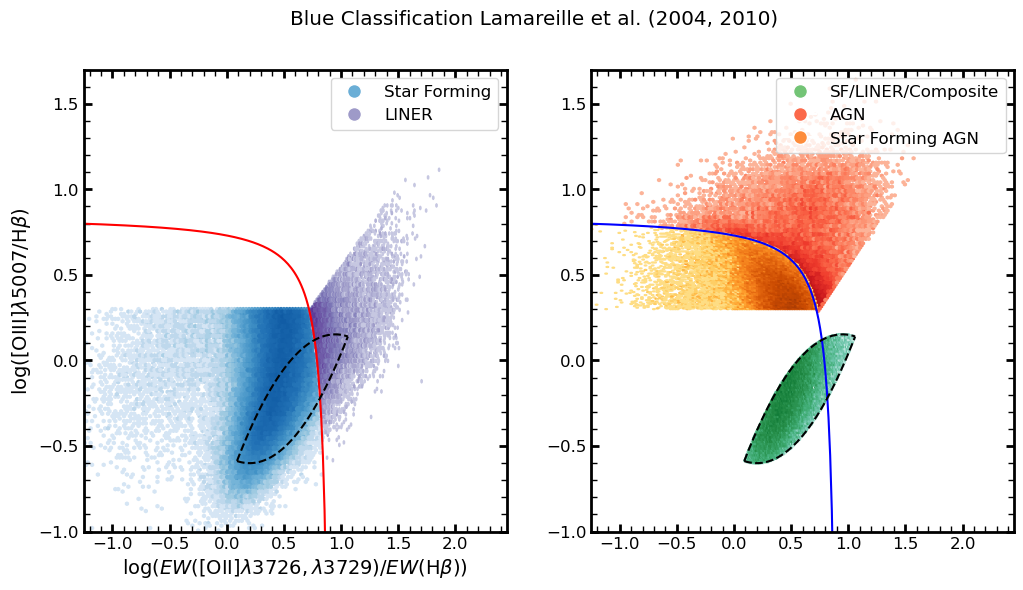

In [31]:
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Star Forming', markerfacecolor=cm.Blues(0.5), markersize=10),
    Line2D([0], [0], marker='o', color='w', label='LINER', markerfacecolor=cm.Purples(0.5), markersize=10),
    ]

fig, (ax, bx) = plt.subplots(ncols=2, figsize=(12, 6))
ax.hexbin(xx_blue[blue_sf_mask], yy_blue[blue_sf_mask], cmap='Blues', bins=100, norm=LogNorm(norm_min, norm_max))
ax.hexbin(xx_blue[blue_liner_mask], yy_blue[blue_liner_mask], cmap='Purples', bins=100, norm=LogNorm(norm_min, norm_max))
ax.plot(xx_blue_main_lines, blue_main_line, color='r')
ax.plot(xx_blue_slc_lines, blue_eq3a, color='k', ls='--')
ax.plot(xx_blue_slc_lines, blue_eq3b, color='k', ls='--')

ax.legend(handles=legend_elements, loc='best')
ax.set(xlabel=r'$\log(EW([\mathrm{OII}]\lambda3726,\lambda 3729) / EW(\mathrm{H}\beta))$',
       ylabel=r'$\log([\mathrm{OIII}]\lambda 5007 / \mathrm{H}\beta)$',
       xlim=[-1.25, 2.45], ylim=[-1., 1.7])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='SF/LINER/Composite', markerfacecolor=cm.Greens(0.5), markersize=10),
    Line2D([0], [0], marker='o', color='w', label='AGN', markerfacecolor=cm.Reds(0.5), markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Star Forming AGN', markerfacecolor=cm.Oranges(0.5), markersize=10)
    ]

bx.hexbin(xx_blue[blue_slc_mask], yy_blue[blue_slc_mask], cmap='BuGn', bins=100, norm=LogNorm(norm_min, norm_max))
bx.hexbin(xx_blue[blue_agn_mask], yy_blue[blue_agn_mask], cmap='Reds', bins=100, norm=LogNorm(norm_min, norm_max))
bx.hexbin(xx_blue[blue_sfagn_mask], yy_blue[blue_sfagn_mask], cmap='YlOrBr', bins=100, norm=LogNorm(norm_min, norm_max))
bx.plot(xx_blue_main_lines, blue_main_line, color='b')
bx.plot(xx_blue_slc_lines, blue_eq3a, color='k', ls='--')
bx.plot(xx_blue_slc_lines, blue_eq3b, color='k', ls='--')


bx.legend(handles=legend_elements, loc='best')
bx.set(xlim=[-1.25, 2.45], ylim=[-1., 1.7])

fig.suptitle('Blue Classification Lamareille et al. (2004, 2010)')
# plt.axis('scaled')
plt.show()

#### 4) MEx (Mass-Excitation) diagnostic diagram

The MEx diagram (Juneau et al. 2011, 2014) is an empirical diagnostic tool used to classify galaxies as Star-Forming, AGN, or Composite/Intermediate systems based on their **stellar mass** ($ \log(M_*/M_{\odot}) $) and **emission-line ratios** ($ \log(\mathrm{[OIII]}/\mathrm{H}\beta) $). Unlike traditional BPT diagrams, which require multiple emission lines, the MEx diagram is useful for high-redshift galaxies where [NII] and Hα may not be available.

For further details, refer to:  
📄 **Juneau et al. (2014)** – ["The Mass-Excitation (MEx) Diagnostic"](https://ui.adsabs.harvard.edu/abs/2014ApJ...788...88J/abstract)

In [32]:
# Stellar mass from T2
log_mass = T2['LOGMSTAR']

# [OIII]/Hbeta flux ratio
oiii_hbeta = np.log10(T2['OIII_5007_FLUX'] / T2['HBETA_FLUX'])

In [33]:
is_mex_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.MEX_SF != 0)
is_mex_intermediate = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.MEX_INTERM != 0)
is_mex_agn = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.MEX_AGN != 0)

In [34]:
# Define the 2014 MEx demarcation lines (Juneau+2014)
def mex_upper_2014(x):
    """AGN vs Composite boundary from Juneau 2014 (Equation 1)"""
    a0, a1, a2, a3 = 410.24, -109.333, 9.71731, -0.288244
    return np.where(x <= 10, 0.375/(x - 10.5) + 1.14, a0 + a1*x + a2*x**2 + a3*x**3)

def mex_lower_2014(x):
    """Composite vs Star-forming boundary from Juneau 2014 (Equation 2)"""
    a0, a1, a2, a3 = 352.066, -93.8249, 8.32651, -0.246416
    return np.where(x <= 9.6, 0.375/(x - 10.5) + 1.14, a0 + a1*x + a2*x**2 + a3*x**3)

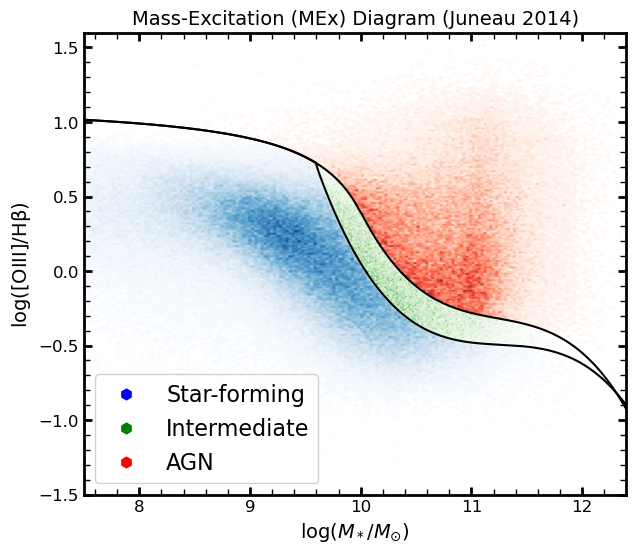

In [35]:
mass_range = np.linspace(7, 13, 200)

plt.figure(figsize=(7, 6))

# Adjust gridsize to make hexagons smaller/bigger
gridsize = 300  

# Hexbin plots for each classification
hb_sf = plt.hexbin(log_mass[is_mex_sf], oiii_hbeta[is_mex_sf], gridsize=gridsize, cmap='Blues', mincnt=1, alpha=0.5)
hb_composite = plt.hexbin(log_mass[is_mex_intermediate], oiii_hbeta[is_mex_intermediate], gridsize=gridsize, cmap='Greens', mincnt=1, alpha=0.5)
hb_agn = plt.hexbin(log_mass[is_mex_agn], oiii_hbeta[is_mex_agn], gridsize=gridsize, cmap='Reds', mincnt=1, alpha=0.5)

# Plot the MEx classification lines
plt.plot(mass_range, mex_upper_2014(mass_range), 'black', linewidth=1.5, label="AGN/SF boundary")  
plt.plot(mass_range, mex_lower_2014(mass_range), 'black', linewidth=1.5, label="Intermediate/SF boundary")  

legend_elements = [
    Line2D([0], [0], marker='h', color='w', markerfacecolor='b', markersize=10, label="Star-forming"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='g', markersize=10, label="Intermediate"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='r', markersize=10, label="AGN")
]
plt.legend(handles=legend_elements, loc='lower left', fontsize=16, framealpha=0.9)

plt.xlabel(r'$\log (M_*/M_{\odot})$', fontsize=14)
plt.ylabel(r'$\log (\mathrm{[OIII]}/\mathrm{H\beta})$', fontsize=14)
plt.xlim(7.5, 12.4)
plt.ylim(-1.5, 1.6)
plt.title("Mass-Excitation (MEx) Diagram (Juneau 2014)", fontsize=14)
plt.show()

#### 5) KEx (Kinematics-Excitation) Diagnostic Diagram  

The KEx diagram (Zhang & Hao 2018) classifies galaxies as Star-Forming , AGN, or Composite/Intermediate based on their **velocity dispersion** ($\log(\sigma_{\mathrm{[OIII]}})$) and **emission-line ratios** ($\log(\mathrm{[OIII]}/\mathrm{H}\beta)$). Unlike the MEx and BPT diagrams, KEx incorporates **kinematic information**, making it valuable for identifying AGN in cases where stellar mass diagnostics may be ambiguous.  

For further details, refer to:  
📄 **Zhang & Hao (2018)** – ["Kinematics-based AGN Identification"](https://ui.adsabs.harvard.edu/abs/2018ApJ...856..171Z/abstract)



In [36]:
# Define KEx classification boundaries (Zhang & Hao 2018)
def kex_upper(sigma_log):
    """AGN vs. SF boundary from Zhang & Hao 2018 (Equation 1)"""
    return -2 * sigma_log + 4.2

def kex_lower(sigma_log):
    """SF vs. Composite boundary from Zhang & Hao 2018 (Equation 2)"""
    return np.full_like(sigma_log, 0.3)  # Constant line at y = 0.3

In [37]:
# Extract velocity dispersion (log scale) from [OIII] sigma
log_sigma_oiii = np.log10(T2['OIII_5007_SIGMA'])  

# Compute log([OIII]/Hβ)
oiii_hbeta = np.log10(T2['OIII_5007_FLUX'] / T2['HBETA_FLUX'])  

In [38]:
is_kex_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.KEX_SF != 0)
is_kex_intermediate = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.KEX_INTERM != 0)
is_kex_agn = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.KEX_AGN != 0)

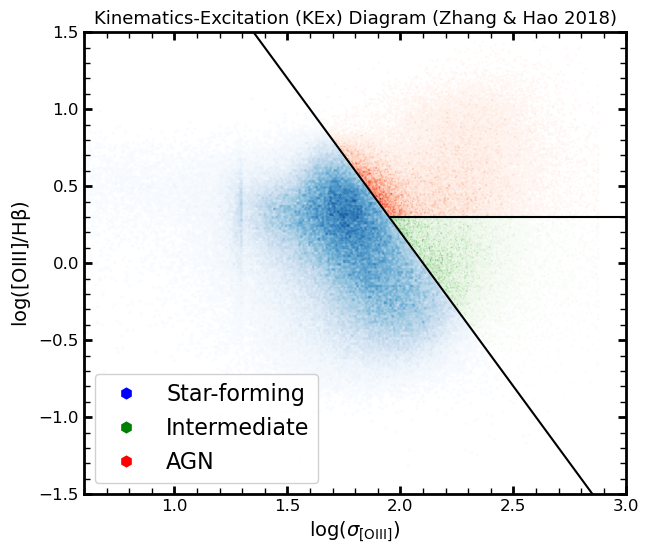

In [39]:
sigma_range = np.linspace(0, 3, 200)

plt.figure(figsize=(7, 6))

# Adjust gridsize to make hexagons smaller
gridsize = 300  

# Hexbin plots for each classification
hb_sf = plt.hexbin(log_sigma_oiii[is_kex_sf], oiii_hbeta[is_kex_sf], gridsize=gridsize, cmap='Blues', mincnt=1, alpha=0.5)
hb_composite = plt.hexbin(log_sigma_oiii[is_kex_intermediate], oiii_hbeta[is_kex_intermediate], gridsize=gridsize, cmap='Greens', mincnt=1, alpha=0.5)
hb_agn = plt.hexbin(log_sigma_oiii[is_kex_agn], oiii_hbeta[is_kex_agn], gridsize=gridsize, cmap='Reds', mincnt=1, alpha=0.5)

# Overlay classification curves
# Overlay AGN/SF boundary
plt.plot(sigma_range, kex_upper(sigma_range), 'black', linewidth=1.5, label="AGN/SF boundary")

# Overlay Composite/SF boundary **only where AGN exists**
sigma_range_composite = sigma_range[sigma_range > 1.95]
plt.plot(sigma_range_composite, kex_lower(sigma_range_composite), 'black', linewidth=1.5, label="Intermediate/SF boundary")

legend_elements = [
    Line2D([0], [0], marker='h', color='w', markerfacecolor='b', markersize=10, label="Star-forming"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='g', markersize=10, label="Intermediate"),
    Line2D([0], [0], marker='h', color='w', markerfacecolor='r', markersize=10, label="AGN")
]
plt.legend(handles=legend_elements, loc='lower left', fontsize=16, framealpha=0.9)

plt.xlabel(r'$\log(\sigma_{\mathrm{[OIII]}})$', fontsize=14)
plt.ylabel(r'$\log (\mathrm{[OIII]}/\mathrm{H\beta})$', fontsize=14)
plt.title("Kinematics-Excitation (KEx) Diagram (Zhang & Hao 2018)", fontsize=13)
plt.ylim(-1.5, 1.5)
plt.xlim(0.6, 3)
plt.show()

#### 6) Infrared (WISE Colors)

[WISE](https://ui.adsabs.harvard.edu/abs/2010AJ....140.1868W/abstract) MIR magnitudes can be used to select AGN - redder colours and brighter photometry can both indicate the presence of an AGN. Diagnostics use various combinations of the four available bands: W1 (3.4 μm), W2 (4.6 μm), W3 (12 μm), and W4 (22 μm). W4 is shallower and more rarely used due to the significant restriction on number of sources available, and in this catalog we focus on diagnostics using W1, W2, and/or W3. These generally assume that the observed MIR is tracing emission from the dusty torus, therefore may be less reliable at higher redshifts where this is no longer the case.

We provide flags for AGN and star-formation indicators for each diagnostic, and an overall flag that indicates the presence of an AGN according to _any_ of the available diagnostics.

References for diagnostics:
* [Jarrett et al., 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...735..112J/abstract)
* [Stern et al., 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...753...30S/abstract)
* [Mateos et al., 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.426.3271M/abstract)
* [Assef et al., 2018](https://ui.adsabs.harvard.edu/abs/2018ApJS..234...23A/abstract)
* [Yao et al., 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...903...91Y/abstract)
* [Hviding et al., 2022](https://ui.adsabs.harvard.edu/abs/2022AJ....163..224H/abstract)

Notes on WISE photometry:
* WISE photometry used here comes from the fastspecfit catalog (https://fastspecfit.readthedocs.io/en/latest/index.html, available at https://data.desi.lbl.gov/public/), which itself is taken from the Legacy Survey forced photometry (https://www.legacysurvey.org/dr10/description/), which is in AB magnitudes. Data taken from other WISE catalogs (e.g., AllWISE, unWISE) is usually in Vega magnitudes, and therefore so are many diagnostic equations. In this notebook we convert the diagnostic equations to AB.
* Legacy Survey forced photometry uses data up to year 7 of NEOWISE for W1 and W2, but W3<sup>1</sup> was not usable after the initial WISE mission duration due to coolant depletion (https://neowise.ipac.caltech.edu/). W1 and W2 will therefore generally be deeper, and caution should be used when combining with W3 if your sources may be variable across that time period.


<sup>1</sup> Similarly W4, which we are not using in this catalog, but is available if needed.

In [40]:
## see available diagnostics
print(IR_TYPE)

IR_TYPE:
  - [WISE_W12,         0, "WISE W1 and W2 available (update_AGNTYPE_WISE_colors)"]
  - [WISE_W123,        1, "WISE W1, W2 and W3 available"]
  - [WISE_AGN_J11,     2, "WISE diagnostic Jarrett et al. 2011 is AGN (based on W1,W2,W3)"]
  - [WISE_SF_J11,      3, "WISE diagnostic Jarrett et al. 2011 is not an AGN (based on W1,W2,W3)"]
  - [WISE_AGN_S12,     4, "WISE diagnostic Stern et al. 2012 is AGN (based on W1,W2)"]
  - [WISE_SF_S12,      5, "WISE diagnostic Stern et al. 2012 is not an AGN (based on W1,W2)"]
  - [WISE_AGN_M12,     6, "WISE diagnostic Mateos et al. 2012 is AGN (based on W1,W2,W3)"]
  - [WISE_SF_M12,      7, "WISE diagnostic Mateos et al. 2012 is not an AGN (based on W1,W2,W3)"]
  - [WISE_AGN_A18,     8, "WISE diagnostic Assef et al. 2018 is AGN (based on W1,W2)"]
  - [WISE_SF_A18,      9, "WISE diagnostic Assef et al. 2018 is not an AGN (based on W1,W2)"]
  - [WISE_AGN_Y20,    10, "WISE diagnostic Yao et al. 2020 is AGN (based on W1,W2,W3)"]
  - [WISE_SF_Y20,   

We can use the same methods as with other diagnostics to retrieve the bitmasks for all sources and plot the resulting distributions. The MIR diagnostics can be used in combination (WISE_ANY_AGN), or can be selected by any single desired diagnostic.

First we should check which sources a WISE diagnostic is available for - although WISE is an all-sky survey, we will exclude measurements with a S/N<3.

In [41]:
## using bitmasks - this is at fixed S/N threshold of >3
has_w1w2 = (T['IR_TYPE'] & IR_TYPE.WISE_W12 != 0)
has_w1w2_only = ((T['IR_TYPE'] & IR_TYPE.WISE_W12 != 0) & (T['IR_TYPE'] & IR_TYPE.WISE_W123==0))
has_w1w2w3 = (T['IR_TYPE'] & IR_TYPE.WISE_W123 != 0)

## WISE colors and W2 mag in AB magnitudes (W1-W2 and W2-W3)
mag_w1 = -2.5*np.log10(T2['FLUX_W1']) + 22.5 # W2 mag
mag_w2 = -2.5*np.log10(T2['FLUX_W2']) + 22.5 # W2 mag
mag_w3 = -2.5*np.log10(T2['FLUX_W3']) + 22.5 # W2 mag
color_w1w2 = -2.5*np.log10(T2['FLUX_W1']/T2['FLUX_W2']) # W1 mag - W2 mag
color_w2w3 = -2.5*np.log10(T2['FLUX_W2']/T2['FLUX_W3']) # W2 mag - W3 mag

Next we can extract the bitmasks and plot the distribution of objects selected as AGN in any diagnostic, along with those selected as Star-forming in any diagnostic:

In [42]:
## retrieve bitmask indicating a WISE AGN in any diagnostic
is_wise_agn_any = (T['AGN_MASKBITS'] & AGN_MASKBITS.WISE_ANY_AGN != 0)

## retrieve bitmask indicating WISE Star-forming galaxy in any diagnostic
is_wise_sf_any = (T['IR_TYPE'] & IR_TYPE.WISE_SF_J11 != 0) |\
                    (T['IR_TYPE'] & IR_TYPE.WISE_SF_S12 != 0) |\
                        (T['IR_TYPE'] & IR_TYPE.WISE_SF_M12 != 0) |\
                            (T['IR_TYPE'] & IR_TYPE.WISE_SF_A18 != 0) |\
                                (T['IR_TYPE'] & IR_TYPE.WISE_SF_Y20 != 0) |\
                                    (T['IR_TYPE'] & IR_TYPE.WISE_SF_H22 != 0)

## these are not exclusive, i.e. an object can be an AGN according to one diagnostic, but SF according to another

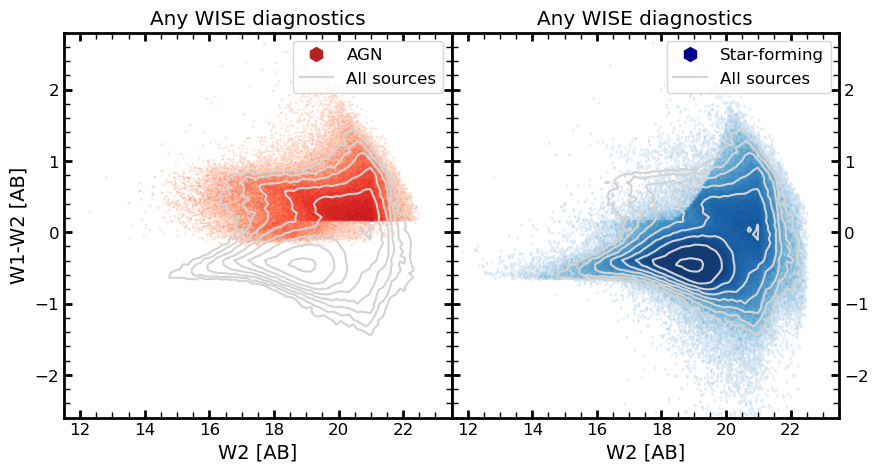

In [43]:
## Figure with separate panel for AGN (left) and SF (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.)

h1, = ax1.plot(np.nan, np.nan, color='firebrick', marker='h', markersize=1, label='AGN', ls='none')
h2, = ax2.plot(np.nan, np.nan, color='darkblue', marker='h', markersize=1, label='Star-forming', ls='none')
h3, = ax1.plot(np.nan, np.nan, color = 'lightgrey', label='All sources')

p0 = ax1.hexbin(mag_w2[is_wise_agn_any&has_w1w2], color_w1w2[is_wise_agn_any&has_w1w2], mincnt=1, gridsize=300, norm=LogNorm(norm_min, norm_max), alpha=0.5, label='AGN', cmap='Reds')
p1 = ax2.hexbin(mag_w2[is_wise_sf_any&has_w1w2], color_w1w2[is_wise_sf_any&has_w1w2], mincnt=1, gridsize=300, norm=LogNorm(norm_min, norm_max), alpha=0.5, label='Star-forming', cmap='Blues')

## add overall contours
# 2-d histogram density of all the galaxies
dens_all,_,_ = np.histogram2d(mag_w2[has_w1w2], color_w1w2[has_w1w2], range=[[11,24],[-3, 3]], bins=100, density=True)
dens_colmag = dens_all.T

levels = np.power(10,np.arange(-2.3,1,0.3))

for ax, h in zip([ax1, ax2], [h1, h2]):
    ax.set_xlabel('W2 [AB]', fontsize=14)
    ax.set_title('Any WISE diagnostics')
    ax.set_xlim(11.5,23.5)
    ax.set_ylim(-2.6,2.8)
    ax.contour(dens_colmag, colors = 'lightgrey', extent = (11, 24, -3, 3), levels=levels)

    ax.legend(handles=[h, h3], markerscale=10)

ax2.tick_params(labelleft=False, labelright=True)
ax1.set_ylabel('W1-W2 [AB]', fontsize=14)

plt.show()

We can also separate out individual diagnostics. These now are exclusive - for example any Assef+18 AGN will not be Assef+18 SF, and vice versa.

In [44]:
is_a18_agn = (T['IR_TYPE'] & IR_TYPE.WISE_AGN_A18 != 0)
is_a18_sf = (T['IR_TYPE'] & IR_TYPE.WISE_SF_A18 != 0)

In [45]:
def assef18_line(reliability=90):
    '''
    Calculates the plot curve for reliability based AGN selection from Assef+18.
    Reliability can be either 90 or 75, according to equations from that work.
    '''
    
    ## 90% reliability
    alpha_90 = 0.65
    beta_90 = 0.153
    gamma_90 = 13.86        
                    
    ## 75% reliability
    alpha_75 = 0.486
    beta_75 = 0.092
    gamma_75 = 13.07 
     
    ## Choose here (default 90%):
    if reliability==90:
        alpha = alpha_90
        beta = beta_90
        gamma = gamma_90
    if reliability==75:
        alpha = alpha_75
        beta = beta_75
        gamma = gamma_75
     
    ## Dummy values for W2 in Vega mags
    xx = np.arange(8, 20, 0.1)
    
    # Offsets from Vega to AB magnitudes (Jarrett+2011) 
    W1_vega2ab = 2.699
    W2_vega2ab = 3.339
    W3_vega2ab = 5.174

    ## Assef+2018 diagnostic
    is_bright_a18 = xx<=gamma
    yy = alpha* np.exp(beta*(xx-gamma)**2)
    yy[is_bright_a18] = alpha
    
    # Return in AB mags for DESI
    return(xx+W2_vega2ab, yy+(W1_vega2ab-W2_vega2ab))

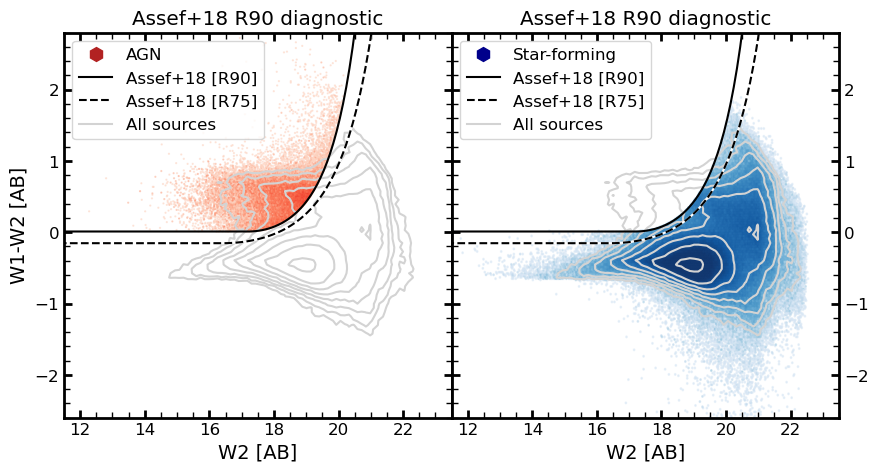

In [46]:
## Figure with separate panel for AGN (left) and SF (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.)

h1, = ax1.plot(np.nan, np.nan, color='firebrick', marker='h', markersize=1, label='AGN', ls='none')
h2, = ax2.plot(np.nan, np.nan, color='darkblue', marker='h', markersize=1, label='Star-forming', ls='none')
h3, = ax1.plot(np.nan, np.nan, color = 'lightgrey', label='All sources')

p0 = ax1.hexbin(mag_w2[is_a18_agn&has_w1w2], color_w1w2[is_a18_agn&has_w1w2], mincnt=1, gridsize=300, norm=LogNorm(norm_min, norm_max), alpha=0.5, label='AGN', cmap='Reds')
p1 = ax2.hexbin(mag_w2[is_a18_sf&has_w1w2], color_w1w2[is_a18_sf&has_w1w2], mincnt=1, gridsize=300, norm=LogNorm(norm_min, norm_max), alpha=0.5, label='Star-forming', cmap='Blues')

## add overall contours
# 2-d histogram density of all the galaxies
dens_all,_,_ = np.histogram2d(mag_w2[has_w1w2], color_w1w2[has_w1w2], range=[[11,24],[-3, 3]], bins=100, density=True)
dens_colmag = dens_all.T

levels = np.power(10,np.arange(-2.3,1,0.3))

# Assef+18 lines for plotting
# note that in Assef+18 Vega magnitudes are used, but in the DESI catalog we use AB magnitudes
# conversions can be found in the function assef18_line above, or see WISE documentation
xx_a18, yy_a18 = assef18_line(reliability=90)
xx_a18_r75, yy_a18_r75 = assef18_line(reliability=75)

for ax, h in zip([ax1, ax2], [h1, h2]):
    ax.set_xlabel('W2 [AB]', fontsize=14)
    ax.set_title('Assef+18 R90 diagnostic')
    ax.set_xlim(11.5,23.5)
    ax.set_ylim(-2.6,2.8)
    ax.contour(dens_colmag, colors = 'lightgrey', extent = (11, 24, -3, 3), levels=levels)

    # Assef+ lines
    h_a18_r90, = ax.plot(xx_a18, yy_a18, color='k', label='Assef+18 [R90]')
    ax.plot(xx_a18_r75, yy_a18_r75, color='w', ls='-')
    h_a18_r75, = ax.plot(xx_a18_r75, yy_a18_r75, color='k', ls='--', label='Assef+18 [R75]')

    ax.legend(handles=[h, h_a18_r90, h_a18_r75, h3], markerscale=10)

ax2.tick_params(labelleft=False, labelright=True)
ax1.set_ylabel('W1-W2 [AB]', fontsize=14)

plt.show()